## Exploratory Data Analysis

### Setup

In [ ]:
# import dependencies
import numpy as np
import pandas as pd
import polars as pl
import math
import re
from collections import Counter

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

In [5]:
# load dataset
X_path = '../../Data/processed/challenger_splits/original/train_X.csv'
y_path = '../../Data/processed/challenger_splits/original/train_y.csv'
train_X = pl.read_csv(X_path)
train_y = pl.read_csv(y_path)

df = train_X.hstack(train_y)

In [6]:
df

User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Zip_str,DateTime,Date,Hour,User_card,State,FICO Score,Yearly Income - Person,Total Debt,Num Credit Cards,Card Brand,Credit Limit,Card on Dark Web,merchant_state_diff,amount_is_refund,amount_log,hour_angle,hour_sin,hour_cos,card_kappa,von_mises_likelihood_card,Is Fraud?
i64,i64,i64,i64,i64,str,f64,str,i64,str,str,f64,i64,str,str,str,str,i64,str,str,i64,f64,f64,i64,str,f64,str,bool,i64,f64,f64,f64,f64,f64,f64,i64
716,0,2011,12,4,"""13:53""",9.07,"""Swipe Transaction""",6780853441840436625,"""Fremont""","""CA""",94536.0,7210,null,"""945""","""2011-12-04T13:53:00.000000""","""2011-12-04""",13,"""716_0""","""CA""",798,68765.0,75608.0,5,"""Mastercard""",39751.0,"""No""",false,0,2.309561,-1.354666,-0.976735,0.214451,0.437183,1.285982,0
835,3,2012,8,18,"""10:41""",52.6,"""Swipe Transaction""",6042526206085641250,"""Bronx""","""NY""",10456.0,5912,null,"""104""","""2012-08-18T10:41:00.000000""","""2012-08-18""",10,"""835_3""","""NY""",712,25434.0,45540.0,4,"""Mastercard""",10500.0,"""No""",false,0,3.981549,-2.155191,-0.834046,-0.551694,0.437183,0.921731,0
1761,0,2009,8,22,"""21:03""",15.85,"""Swipe Transaction""",6246550243095942766,"""Cocoa""","""FL""",32926.0,5921,null,"""329""","""2009-08-22T21:03:00.000000""","""2009-08-22""",21,"""1761_0""","""FL""",644,12796.0,22192.0,3,"""Visa""",9661.0,"""No""",false,0,2.824351,0.726348,0.664144,0.747605,0.437183,1.208288,0
1315,1,2017,8,6,"""08:23""",10.7,"""Chip Transaction""",4722913068560264812,"""Perrysburg""","""OH""",43551.0,5411,null,"""435""","""2017-08-06T08:23:00.000000""","""2017-08-06""",8,"""1315_1""","""OR""",680,38194.0,1674.0,3,"""Mastercard""",9707.0,"""No""",true,0,2.459589,2.101667,0.862366,-0.506285,0.437183,0.704784,0
1809,1,2011,10,15,"""19:51""",58.14,"""Swipe Transaction""",4123806141501734555,"""Billings""","""MT""",59102.0,4900,null,"""591""","""2011-10-15T19:51:00.000000""","""2011-10-15""",19,"""1809_1""","""MT""",695,41249.0,42268.0,2,"""Mastercard""",16187.0,"""No""",false,0,4.079908,0.207403,0.20592,0.978569,0.437183,1.432991,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
748,1,2015,12,6,"""00:56""",-350.0,"""Chip Transaction""",1715299929786123066,"""Lemoore""","""CA""",93245.0,3722,null,"""932""","""2015-12-06T00:56:00.000000""","""2015-12-06""",0,"""748_1""","""CA""",702,51465.0,0.0,2,"""Mastercard""",12200.0,"""No""",false,1,-5.860786,0.002327,0.002327,0.999997,0.437183,1.49602,0
1093,0,2018,9,8,"""15:38""",12.12,"""Chip Transaction""",8438446124682714015,"""Cairo""","""IL""",62914.0,5541,null,"""629""","""2018-09-08T15:38:00.000000""","""2018-09-08""",15,"""1093_0""","""IL""",705,34311.0,61776.0,2,"""Mastercard""",72.0,"""No""",false,0,2.574138,-0.840667,-0.745088,0.666966,0.437183,1.484136,0
1886,2,2014,5,28,"""11:38""",186.0,"""Swipe Transaction""",-6161792371494728879,"""Nassau""","""The Bahamas""",null,3389,null,"""NON""","""2014-05-28T11:38:00.000000""","""2014-05-28""",11,"""1886_2""","""PA""",742,37579.0,0.0,5,"""Visa""",10700.0,"""No""",true,0,5.231109,-1.887864,-0.950154,-0.311782,0.437183,1.035467,0


In [30]:
df.describe()

statistic,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Zip_str,DateTime,Date,Hour,User_card,State,FICO Score,Yearly Income - Person,Total Debt,Num Credit Cards,Card Brand,Credit Limit,Card on Dark Web,merchant_state_diff,amount_is_refund,amount_log,hour_angle,hour_sin,hour_cos,card_kappa,von_mises_likelihood_card,Is Fraud?
str,f64,f64,f64,f64,f64,str,f64,str,f64,str,str,f64,f64,str,str,str,str,f64,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",9.75476e6,9.75476e6,9.75476e6,9.75476e6,9.75476e6,"""9754760""",9.75476e6,"""9754760""",9.75476e6,"""9754760""","""9754760""",8.604157e6,9.75476e6,"""154759""","""9754760""","""9754760""","""9754760""",9.75476e6,"""9754760""","""9754760""",9.75476e6,9.75476e6,9.75476e6,9.75476e6,"""9754760""",9.75476e6,"""9754760""",9.75476e6,9.75476e6,9.75476e6,9.75476e6,9.75476e6,9.75476e6,9.75476e6,9.75476e6,9.75476e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""",1.150603e6,0.0,"""9600001""","""0""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1000.931256,1.352178,2011.955174,6.525206,15.720386,null,43.622803,null,-4.7859e17,null,null,50959.290625,5561.435023,null,null,null,null,12.412644,null,null,712.388124,46602.607902,58513.485549,3.683789,null,15249.244455,null,0.200283,0.050953,2.925081,-0.034098,-0.08254,0.196941,0.437183,1.138944,0.001208
"""std""",569.4656,1.407624,5.106,3.472877,8.793283,null,81.792299,null,4.7592e18,null,null,29395.493228,879.377407,null,null,null,null,5.066111,null,null,67.053336,24466.324131,52570.180662,1.623955,null,12174.170493,null,null,0.219901,2.09353,1.472348,0.796983,0.564995,5.5511e-17,0.295401,0.034737
"""min""",0.0,0.0,1991.0,1.0,1.0,"""00:00""",-500.0,"""Chip Transaction""",-9.2229e18,"""Aaronsburg""","""AA""",1001.0,1711.0,"""Bad CVV""","""100""","""1991-01-03T11:14:00.000000""","""1991-01-03""",0.0,"""0_0""","""AK""",480.0,1.0,0.0,1.0,"""Amex""",0.0,"""No""",0.0,0.0,-6.216606,-2.157227,-0.99901,-0.713454,0.437183,0.666259,0.0
"""25%""",510.0,0.0,2008.0,3.0,8.0,null,9.2,null,-4.5055e18,null,null,28375.0,5300.0,null,null,null,null,9.0,null,null,683.0,32716.0,17392.0,3.0,null,7676.0,null,null,0.0,2.322388,-1.361066,-0.890874,-0.306803,0.437183,0.847103,0.0
"""50%""",1006.0,1.0,2013.0,7.0,16.0,null,30.13,null,-7.9481e17,null,null,46742.0,5499.0,null,null,null,null,12.0,null,null,714.0,40848.0,51679.0,4.0,null,13325.0,null,null,0.0,3.438172,-0.312414,-0.307357,0.206773,0.437183,1.15925,0.0
"""75%""",1477.0,2.0,2016.0,10.0,23.0,null,65.03,null,3.1895e18,null,null,77564.0,5812.0,null,null,null,null,16.0,null,null,755.0,53996.0,84935.0,5.0,null,20318.0,null,null,0.0,4.190109,1.563233,0.834207,0.742561,0.437183,1.412246,0.0
"""max""",1999.0,8.0,2020.0,12.0,31.0,"""23:59""",6261.69,"""Swipe Transaction""",9.2229e18,"""Zwolle""","""Zimbabwe""",99928.0,9402.0,"""Technical Glitch""","""ONL""","""2020-02-28T23:53:00.000000""","""2020-02-28""",23.0,"""9_0""","""WY""",850.0,307018.0,516263.0,9.0,"""Visa""",151223.0,"""No""",1.0,1.0,8.742365,2.365212,1.0,1.0,0.437183,1.546575,1.0


In [31]:
fraud_df = (df.filter(pl.col("Is Fraud?") == 1))
fraud_df.describe()

statistic,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Zip_str,DateTime,Date,Hour,User_card,State,FICO Score,Yearly Income - Person,Total Debt,Num Credit Cards,Card Brand,Credit Limit,Card on Dark Web,merchant_state_diff,amount_is_refund,amount_log,hour_angle,hour_sin,hour_cos,card_kappa,von_mises_likelihood_card,Is Fraud?
str,f64,f64,f64,f64,f64,str,f64,str,f64,str,str,f64,f64,str,str,str,str,f64,str,str,f64,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",11785.0,11785.0,11785.0,11785.0,11785.0,"""11785""",11785.0,"""11785""",11785.0,"""11785""","""11785""",1928.0,11785.0,"""522""","""11785""","""11785""","""11785""",11785.0,"""11785""","""11785""",11785.0,11785.0,11785.0,11785.0,"""11785""",11785.0,"""11785""",11785.0,11785.0,11785.0,11785.0,11785.0,11785.0,11785.0,11785.0,11785.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""",9857.0,0.0,"""11263""","""0""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1004.540008,1.611116,2011.973101,6.642087,15.728808,null,111.253804,null,3.1002e16,null,null,53063.845436,5242.566228,null,null,null,null,11.708273,null,null,717.298345,44608.218159,53744.196691,4.16801,null,14047.945948,null,0.877811,0.035554,3.711384,-0.420816,-0.317489,0.109746,0.437183,1.141625,1.0
"""std""",558.175041,1.497643,4.611341,3.45881,8.85497,null,197.659131,null,4.9153e18,null,null,28377.365571,982.270133,null,null,null,null,3.993004,null,null,63.894264,23742.460507,50482.864231,1.635469,null,11832.158094,null,null,0.185182,2.295072,1.498367,0.765109,0.5494,5.5514e-17,0.28723,0.0
"""min""",0.0,0.0,1996.0,1.0,1.0,"""00:01""",-500.0,"""Chip Transaction""",-9.1951e18,"""Aberdeen""","""AK""",1451.0,3000.0,"""Bad CVV""","""100""","""1996-07-05T11:11:00.000000""","""1996-07-05""",0.0,"""0_0""","""AL""",488.0,1.0,0.0,1.0,"""Amex""",0.0,"""No""",0.0,0.0,-6.216606,-2.157227,-0.99901,-0.713454,0.437183,0.666259,1.0
"""25%""",533.0,0.0,2008.0,4.0,8.0,null,19.55,null,-4.2825e18,null,null,32809.0,4829.0,null,null,null,null,9.0,null,null,686.0,31550.0,14542.0,3.0,null,6700.0,null,null,0.0,3.022861,-1.626356,-0.950516,-0.315925,0.437183,0.923577,1.0
"""50%""",1011.0,1.0,2012.0,7.0,16.0,null,73.56,null,-2.4518e17,null,null,44824.0,5311.0,null,null,null,null,12.0,null,null,718.0,39508.0,46298.0,4.0,null,12358.0,null,null,0.0,4.311604,-0.84503,-0.747991,-0.002909,0.437183,1.15814,1.0
"""75%""",1479.0,3.0,2016.0,10.0,23.0,null,153.48,null,4.5529e18,null,null,79065.0,5719.0,null,null,null,null,14.0,null,null,759.0,51703.0,80367.0,5.0,null,19037.0,null,null,0.0,5.040065,0.784525,0.701531,0.664796,0.437183,1.398186,1.0
"""max""",1997.0,8.0,2019.0,12.0,31.0,"""23:59""",5694.44,"""Swipe Transaction""",9.2040e18,"""Zephyrhills""","""WY""",99504.0,9402.0,"""Technical Glitch""","""ONL""","""2019-10-27T14:31:00.000000""","""2019-10-27""",23.0,"""9_0""","""WY""",850.0,280199.0,461854.0,9.0,"""Visa""",151223.0,"""No""",1.0,1.0,8.647421,2.365212,1.0,1.0,0.437183,1.546575,1.0


### Transaction Analysis

Percentage of transactions by fraud status:
Is Fraud?
0    99.879187
1     0.120813
Name: proportion, dtype: float64


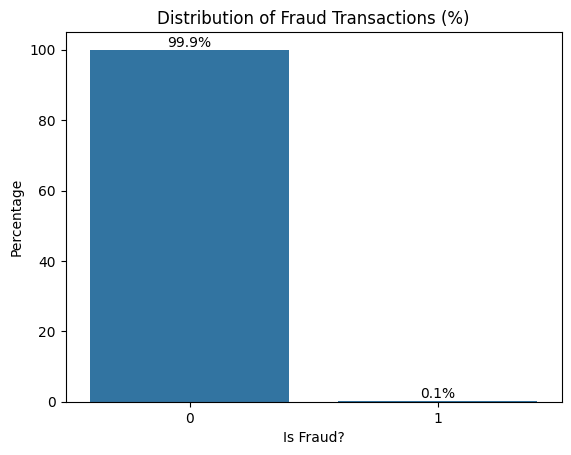

In [32]:
# plot percentage of fraud transactions
fraud_counts = df.to_pandas()["Is Fraud?"].value_counts(normalize=True) * 100

print("Percentage of transactions by fraud status:")
print(fraud_counts)

ax = sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Distribution of Fraud Transactions (%)")
plt.ylabel("Percentage")
plt.xlabel("Is Fraud?")
plt.ylim(0, 105)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() + 1,
        f"{p.get_height():.1f}%",
        ha='center'
    )

plt.show()          # severe class imbalance

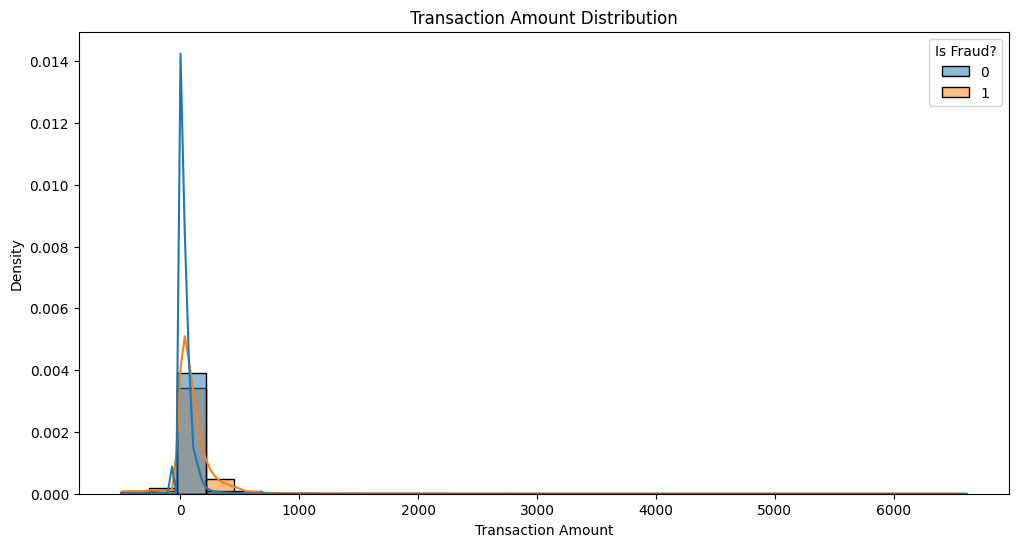

Is Fraud?
0     43.561998
1    106.095315
Name: Amount, dtype: float64

In [4]:
# plot distribution of transaction amount by fraud status
df_amt = df.select([
    "Amount",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_amt, 
    x="Amount", 
    hue="Is Fraud?", 
    bins=30, 
    kde=True, 
    stat="density", 
    common_norm=False
)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.show()      # amounts are highly right-skewed

# average transactions amount by fraud status
df_amt.groupby("Is Fraud?")["Amount"].mean()

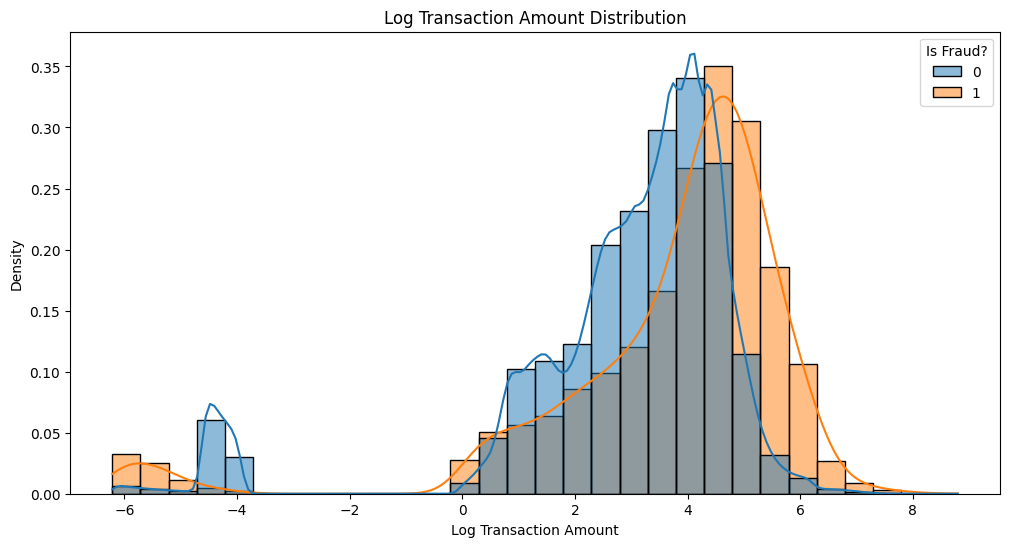

Is Fraud?
0    2.923898
1    3.652573
Name: amount_log, dtype: float64

In [5]:
# plot distribution of log transaction amount by fraud status
df_log_amt = df.select([
    "amount_log",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_log_amt, 
    x="amount_log", 
    hue="Is Fraud?", 
    bins=30, 
    kde=True, 
    stat="density", 
    common_norm=False
)
plt.title("Log Transaction Amount Distribution")
plt.xlabel("Log Transaction Amount")
plt.ylabel("Density")
plt.show()      # fraud transactions tend to be of higher value, regardless of whether it is a refund

# average log transactions amount by fraud status
df_log_amt.groupby("Is Fraud?")["amount_log"].mean()

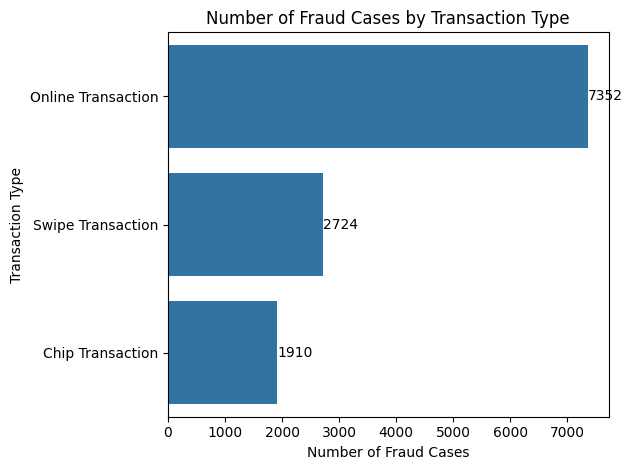

In [20]:
# plot number of fraud cases by transaction type
fraud_by_txn_type = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("Use Chip")
      .agg(pl.len().alias("Fraud_Count"))
      .sort("Fraud_Count", descending=True)
      .head(15)
      .to_pandas()
)

ax = sns.barplot(x="Fraud_Count", y="Use Chip", data=fraud_by_txn_type)
for p in ax.patches:
  width = p.get_width()
  ax.text(
      x=width + 1,
      y=p.get_y() + p.get_height()/2,
      s=int(width),
      ha='left',
      va='center'
  )
plt.title("Number of Fraud Cases by Transaction Type")
plt.ylabel("Transaction Type")
plt.xlabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()    # majority of fraud cases are online transactions

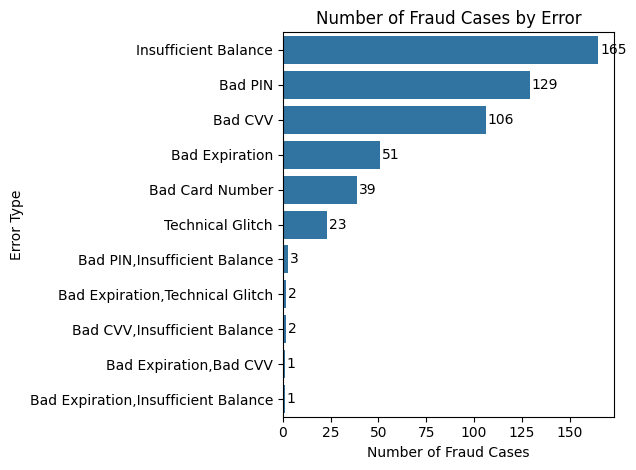

In [33]:
# plot number of fraud cases by errors
fraud_by_error = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("Errors?")
      .agg(pl.len().alias("Fraud_Count"))
      .sort("Fraud_Count", descending=True)
      .head(15)
      .to_pandas()
)

ax = sns.barplot(x="Fraud_Count", y="Errors?", data=fraud_by_error)
for p in ax.patches:
  width = p.get_width()
  ax.text(
      x=width + 1,
      y=p.get_y() + p.get_height()/2,
      s=int(width),
      ha='left',
      va='center'
  )
plt.title("Number of Fraud Cases by Error")
plt.ylabel("Error Type")
plt.xlabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()

### Card Analysis

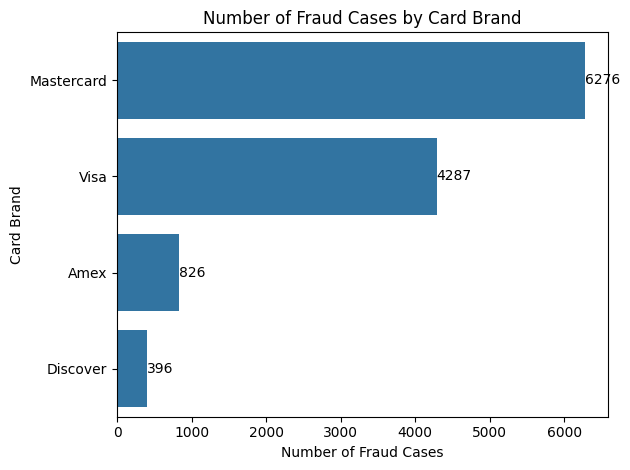

In [38]:
# plot number of fraud cases by card brand
fraud_by_brand = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("Card Brand")
      .agg(pl.len().alias("brand_count"))
      .sort("brand_count", descending=True)
      .head(15)
      .to_pandas()
)

ax = sns.barplot(x="brand_count", y="Card Brand", data=fraud_by_brand, orient="h")
for p in ax.patches:
  width = p.get_width()
  ax.text(
      x=width + 1,
      y=p.get_y() + p.get_height()/2,
      s=int(width),
      ha='left',
      va='center'
  )
plt.title("Number of Fraud Cases by Card Brand")
plt.ylabel("Card Brand")
plt.xlabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()      # highest number of fraud cases with Mastercard

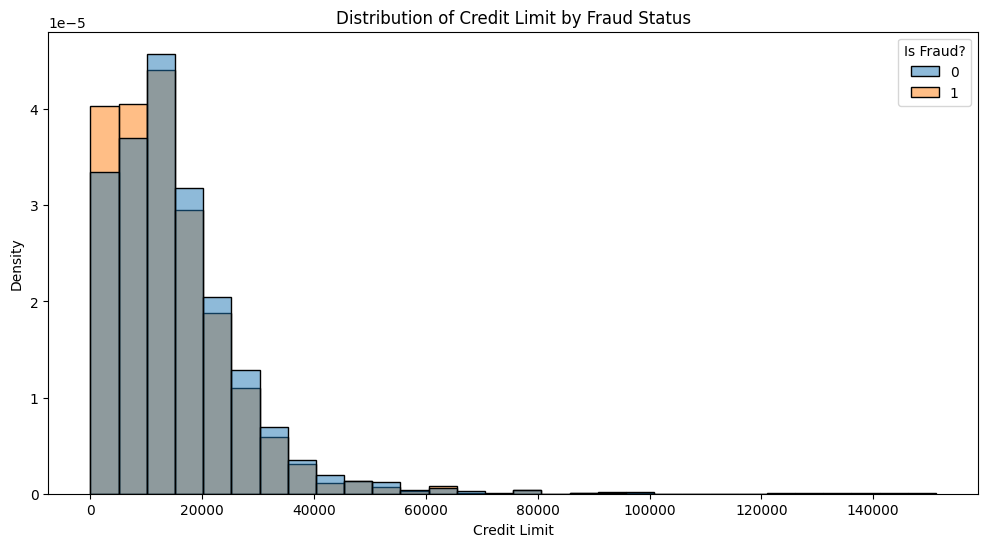

Is Fraud?
0    15250.697533
1    14047.945948
Name: Credit Limit, dtype: float64

In [54]:
# plot distribution of card credit limit by fraud status
df_credit_limit = df.select([
    "Credit Limit",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_credit_limit, 
    x="Credit Limit", 
    hue="Is Fraud?", 
    bins=30, 
    kde=False, 
    stat="density", 
    common_norm=False
)
plt.title("Distribution of Credit Limit by Fraud Status")
plt.xlabel("Credit Limit")
plt.ylabel("Density")
plt.show()      # fraudulent users tend to have a slightly lower credit limit

# average credit limit by fraud status
df_credit_limit.groupby("Is Fraud?")["Credit Limit"].mean()

### Merchant Analysis

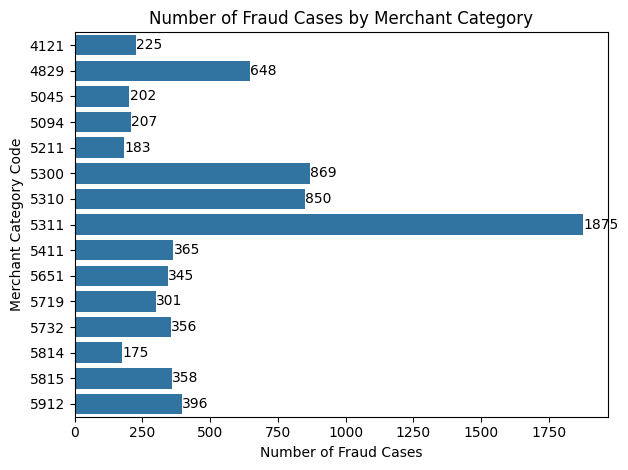

In [35]:
# plot number of fraud cases by merchant category
fraud_by_mcc = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("MCC")
      .agg(pl.len().alias("Fraud_Count"))
      .sort("Fraud_Count", descending=True)
      .head(15)
      .to_pandas()
)

ax = sns.barplot(x="Fraud_Count", y="MCC", data=fraud_by_mcc, orient="h")
for p in ax.patches:
  width = p.get_width()
  ax.text(
      x=width + 1,
      y=p.get_y() + p.get_height()/2,
      s=int(width),
      ha='left',
      va='center'
  )
plt.title("Number of Fraud Cases by Merchant Category")
plt.ylabel("Merchant Category Code")
plt.xlabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()      # highest number of fraud cases in department stores (5311)

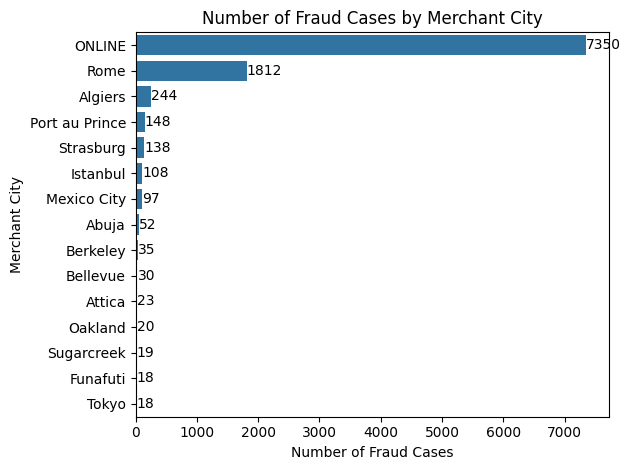

In [36]:
# plot number of fraud cases by merchant city
fraud_by_city = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("Merchant City")
      .agg(pl.len().alias("Fraud_Count"))
      .sort("Fraud_Count", descending=True)
      .head(15)
      .to_pandas()
)

ax = sns.barplot(x="Fraud_Count", y="Merchant City", data=fraud_by_city)
for p in ax.patches:
  width = p.get_width()
  ax.text(
      x=width + 1,
      y=p.get_y() + p.get_height()/2,
      s=int(width),
      ha='left',
      va='center'
  )
plt.title("Number of Fraud Cases by Merchant City")
plt.ylabel("Merchant City")
plt.xlabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()      # besides online merchants, majority of fraud are outside of US

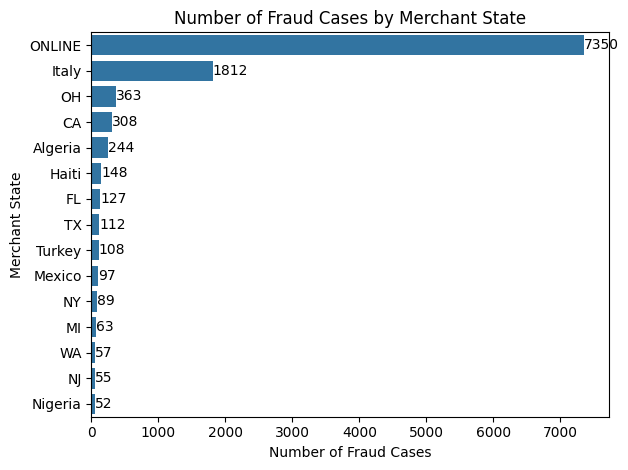

In [37]:
# plot number of fraud cases by merchant state
fraud_by_state = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("Merchant State")
      .agg(pl.len().alias("Fraud_Count"))
      .sort("Fraud_Count", descending=True)
      .head(15)
      .to_pandas()
)

ax = sns.barplot(x="Fraud_Count", y="Merchant State", data=fraud_by_state)
for p in ax.patches:
  width = p.get_width()
  ax.text(
      x=width + 1,
      y=p.get_y() + p.get_height()/2,
      s=int(width),
      ha='left',
      va='center'
  )
plt.title("Number of Fraud Cases by Merchant State")
plt.ylabel("Merchant State")
plt.xlabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()    

In [ ]:
# to see if there are any geographical patterns
# us states
us_states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS",
    "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
    "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV",
    "WI", "WY", "DC"
]

# aggregate fraud counts by state
fraud_by_state = (
    df.filter(pl.col("Merchant State").is_in(us_states))
      .filter(pl.col("Is Fraud?") == 1)
      .group_by("Merchant State")
      .agg(pl.len().alias("Fraud_Count"))
      .sort("Fraud_Count", descending=True)
      .to_pandas()
)

# plot choropleth map
fig = px.choropleth(
    fraud_by_state,
    locations="Merchant State",
    locationmode="USA-states",
    color="Fraud_Count",
    scope="usa",
    title="Fraud Cases by U.S. State",
    labels={"Fraud_Count": "Number of Fraud Cases"}
)

for i, row in fraud_by_state.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        locations=[row["Merchant State"]],
        text=f"{row['Merchant State']}<br>{row['Fraud_Count']}",
        mode='text',
        textfont=dict(color="black", size=7, family="Arial"),
        showlegend=False
    ))

fig.update_layout(
    geo=dict(
        scope="usa",
        projection=go.layout.geo.Projection(type="albers usa"),
        showlakes=True,
        lakecolor="rgb(255, 255, 255)"
    ),
    title_x=0.3, 
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
)

fig.show()

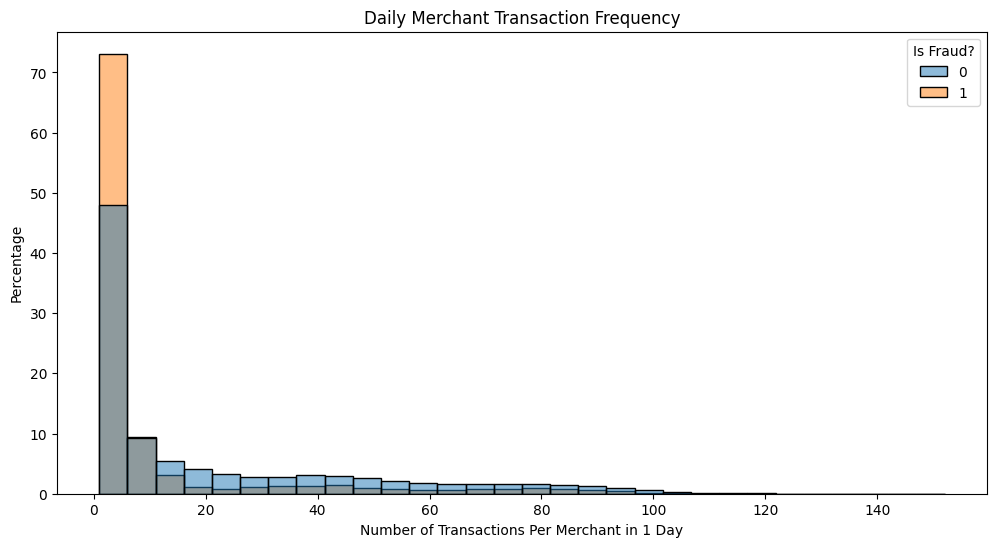

Is Fraud?
0    21.247958
1    10.293509
Name: Merchant_Freq_Day, dtype: float64

In [77]:
# get frequency of merchant transactions in 1 day
df_daily_freq = df.with_columns([
    (pl.col("Merchant Name").cast(pl.Utf8) + "_" + 
     pl.col("Date").cast(pl.Utf8)).alias("Merchant_Date")
])

df_daily_freq = df_daily_freq.with_columns([
    pl.col("Merchant_Date").count().over("Merchant_Date").alias("Merchant_Freq_Day")
])

merchant_daily_freq = df_daily_freq.select([
    "Merchant_Freq_Day", "Is Fraud?"
]).to_pandas()

# plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(
    data=merchant_daily_freq,
    x="Merchant_Freq_Day",
    hue="Is Fraud?",
    bins=30,
    kde=False,  
    stat="percent",
    common_norm=False
)
plt.title("Daily Merchant Transaction Frequency")
plt.xlabel("Number of Transactions Per Merchant in 1 Day")
plt.ylabel("Percentage")
plt.show()

# average daily user transactions
merchant_daily_freq.groupby("Is Fraud?")["Merchant_Freq_Day"].mean()

### User Analysis

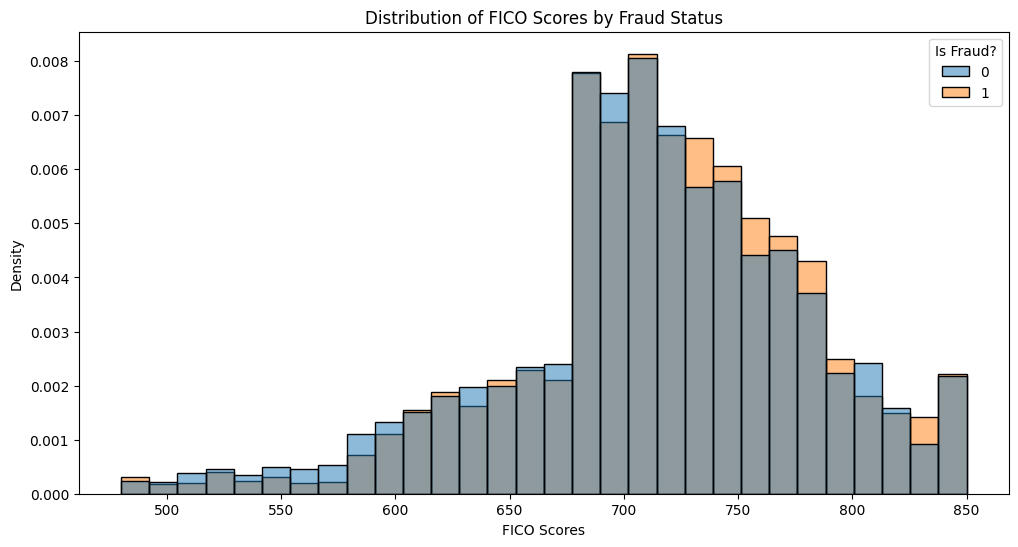

Is Fraud?
0    712.394516
1    717.522359
Name: FICO Score, dtype: float64

In [97]:
# plot distribution of FICO score by fraud status
df_fico = df.select([
    "FICO Score",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_fico, 
    x="FICO Score", 
    hue="Is Fraud?", 
    bins=30, 
    kde=False, 
    stat="density", 
    common_norm=False
)
plt.title("Distribution of FICO Scores by Fraud Status")
plt.xlabel("FICO Scores")
plt.ylabel("Density")
plt.show()     

# average FICO score by fraud status
df_fico.groupby("Is Fraud?")["FICO Score"].mean()

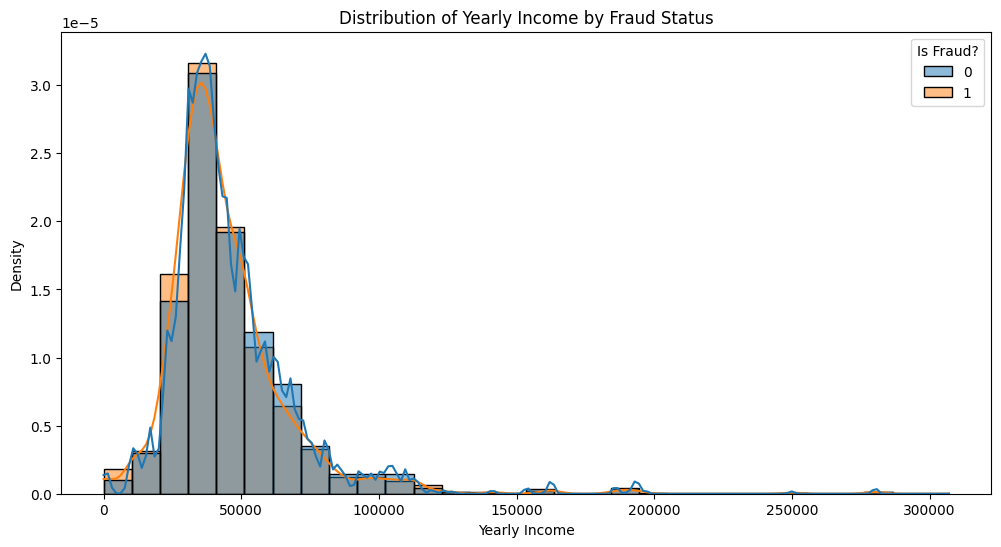

Is Fraud?
0    46605.020295
1    44608.218159
Name: Yearly Income - Person, dtype: float64

In [55]:
# plot distribution of users' yearly income by fraud status
df_income = df.select([
    "Yearly Income - Person",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_income, 
    x="Yearly Income - Person", 
    hue="Is Fraud?", 
    bins=30, 
    kde=True, 
    stat="density", 
    common_norm=False
)
plt.title("Distribution of Yearly Income by Fraud Status")
plt.xlabel("Yearly Income")
plt.ylabel("Density")
plt.show()      

# average yearly income by fraud status
df_income.groupby("Is Fraud?")["Yearly Income - Person"].mean()

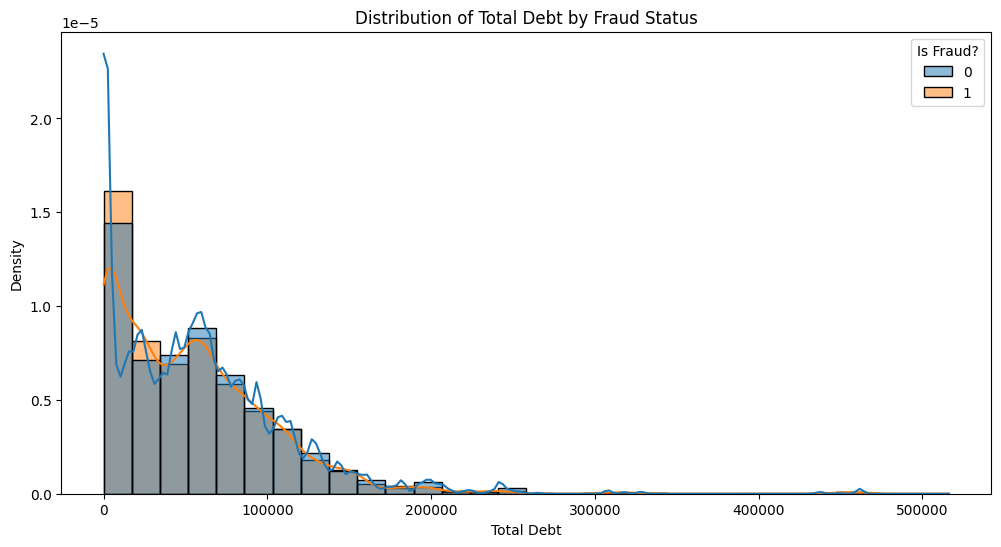

Is Fraud?
0    58519.254430
1    53744.196691
Name: Total Debt, dtype: float64

In [56]:
# plot distribution of users' total debt by fraud status
df_debt = df.select([
    "Total Debt",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_debt, 
    x="Total Debt", 
    hue="Is Fraud?", 
    bins=30, 
    kde=True, 
    stat="density", 
    common_norm=False
)
plt.title("Distribution of Total Debt by Fraud Status")
plt.xlabel("Total Debt")
plt.ylabel("Density")
plt.show()      

# average debt amount by fraud status
df_debt.groupby("Is Fraud?")["Total Debt"].mean()

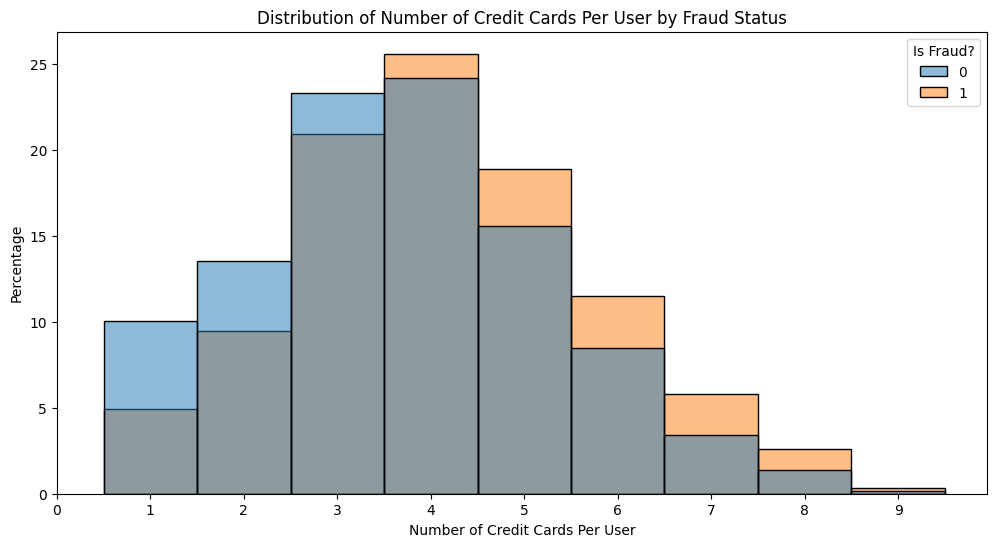

Is Fraud?
0    3.683204
1    4.168010
Name: Num Credit Cards, dtype: float64

In [57]:
# get distribution of fraud cases by number of credit cards per user
df_num_cards = df.select([
    "Num Credit Cards",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_num_cards, 
    x="Num Credit Cards", 
    hue="Is Fraud?", 
    bins=30, 
    kde=False, 
    stat="percent", 
    common_norm=False, 
    discrete=True
)
plt.title("Distribution of Number of Credit Cards Per User by Fraud Status")
plt.xlabel("Number of Credit Cards Per User")
plt.ylabel("Percentage")
max_val = int(df_num_cards["Num Credit Cards"].max())
plt.xticks(np.arange(0, max_val + 1, 1))
plt.show()      # users who own cards used for fraud tend to have more credit cards

# average number of credit cards by fraud status
df_num_cards.groupby("Is Fraud?")["Num Credit Cards"].mean()

### Behaviour Analysis

Percentage of different state transactions by fraud status:
   Is Fraud?  merchant_state_diff  Percentage
0          0                False   80.053639
1          0                 True   19.946361
2          1                 True   87.781078
3          1                False   12.218922


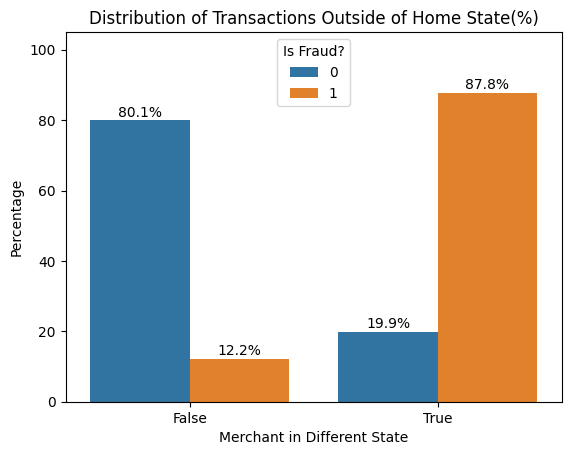

In [41]:
# plot distribution of merchant_state_diff by fraud status
state_diff_df = df.select([
    "merchant_state_diff",
    "Is Fraud?"
]).to_pandas()

state_diff_pct = (
  state_diff_df.groupby("Is Fraud?")["merchant_state_diff"]
                   .value_counts(normalize=True)
                   .mul(100)
                   .rename("Percentage")
                   .reset_index()
)

print("Percentage of different state transactions by fraud status:")
print(state_diff_pct)

ax = sns.barplot(
    data=state_diff_pct,
    x="merchant_state_diff", 
    y="Percentage", 
    hue="Is Fraud?",
    dodge=True)

plt.title("Distribution of Transactions Outside of Home State(%)")
plt.ylabel("Percentage")
plt.xlabel("Merchant in Different State")
plt.ylim(0, 105)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
      ax.text(
          p.get_x() + p.get_width()/2,
          p.get_height() + 1,
          f"{p.get_height():.1f}%",
          ha='center'
      )

plt.show()      # 87.2% of fraud cases happen when user state != merchant state

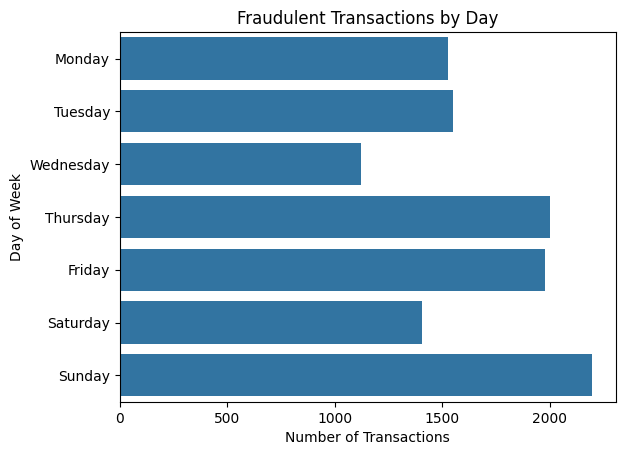

In [42]:
# get day of week
df_day = df.with_columns([
    pl.col("DateTime").str.strptime(pl.Datetime, strict=False).alias("DateTime")
])
df_day = df_day.with_columns([
    pl.col("DateTime").dt.weekday().alias("DayOfWeek")
])

# plot fraudulent transactions by day of week
fraud_by_day = (
    df_day.group_by(["DayOfWeek", "Is Fraud?"])
          .agg(pl.len().alias("Count"))
          .sort("DayOfWeek")
          .filter(pl.col("Is Fraud?") == 1)
          .to_pandas()
)

# map day numbers to names
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
             5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
fraud_by_day['DayName'] = fraud_by_day['DayOfWeek'].map(day_names)

sns.barplot(x="Count", y="DayName", data=fraud_by_day)
plt.title("Fraudulent Transactions by Day")
plt.xlabel("Number of Transactions")
plt.ylabel("Day of Week")
plt.show()      # fraud tends to occur on Sundays, followed by Thursdays and Fridays

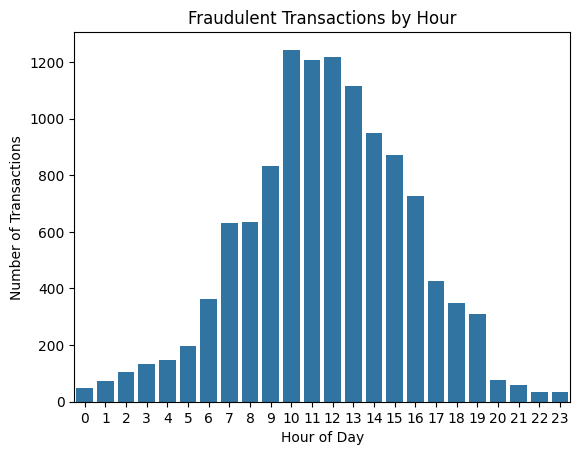

In [43]:
# plot fraudulent transactions by hour
fraud_by_hour = (
    df.group_by(["Hour", "Is Fraud?"])
      .agg(pl.len().alias("Count"))
      .sort("Hour")
      .filter(pl.col("Is Fraud?") == 1)
      .to_pandas()
)

sns.barplot(x="Hour", y="Count", data=fraud_by_hour)
plt.title("Fraudulent Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()      # most fraud transactions occur during the day
                # only a low proportion occurs during abnormal hours

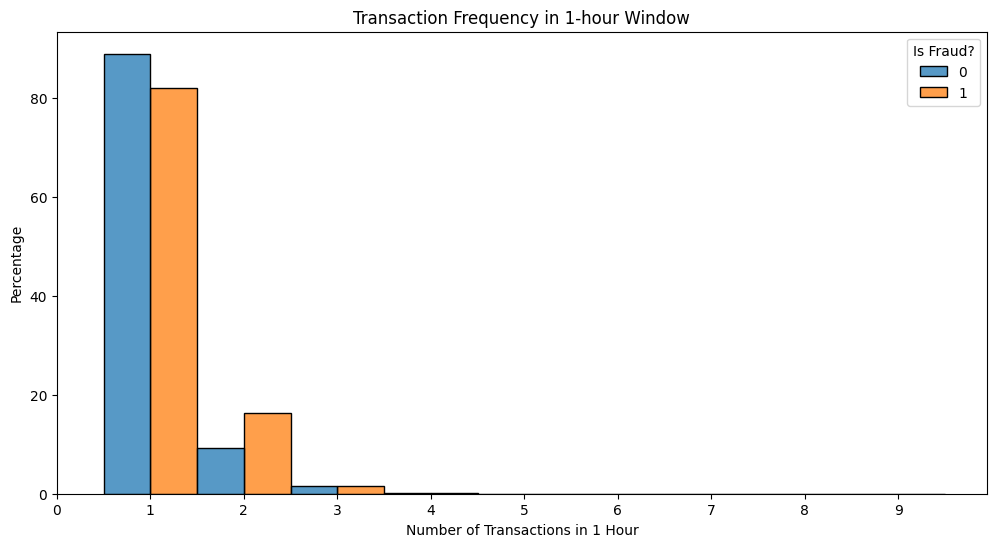

Is Fraud?
0    1.130454
1    1.199629
Name: txn_count_1h, dtype: float64

In [44]:
# get frequency of user transactions in 1 hour window
df_user_sorted = df.with_columns(
    pl.col("DateTime").str.strptime(pl.Datetime, strict=False)
).sort(["User_card", "DateTime"])

df_rolled = (
    df_user_sorted.rolling(index_column="DateTime", period="1h", group_by="User_card")
                  .agg([pl.len().alias("txn_count_1h")])
)

# join back to df
df_rolled = df_user_sorted.join(
    df_rolled,
    on=["User_card", "DateTime"],
    how="left"
).with_columns(
    pl.col("txn_count_1h").fill_null(0).cast(pl.Int64)
)

df_freq = df_rolled.select([
    "txn_count_1h",
    "Is Fraud?"
]).to_pandas()

# plot distribution 
plt.figure(figsize=(12,6))
sns.histplot(
    data=df_freq, 
    x="txn_count_1h", 
    hue="Is Fraud?", 
    bins=30, 
    kde=False, 
    stat="percent", 
    common_norm=False, 
    discrete=True,
    multiple="dodge"
)
plt.title("Transaction Frequency in 1-hour Window")
plt.xlabel("Number of Transactions in 1 Hour")
plt.ylabel("Percentage")
max_val = int(df_freq["txn_count_1h"].max())
plt.xticks(np.arange(0, max_val + 1, 1))
plt.show()

# average transactions per hour by fraud status
df_freq.groupby("Is Fraud?")["txn_count_1h"].mean()

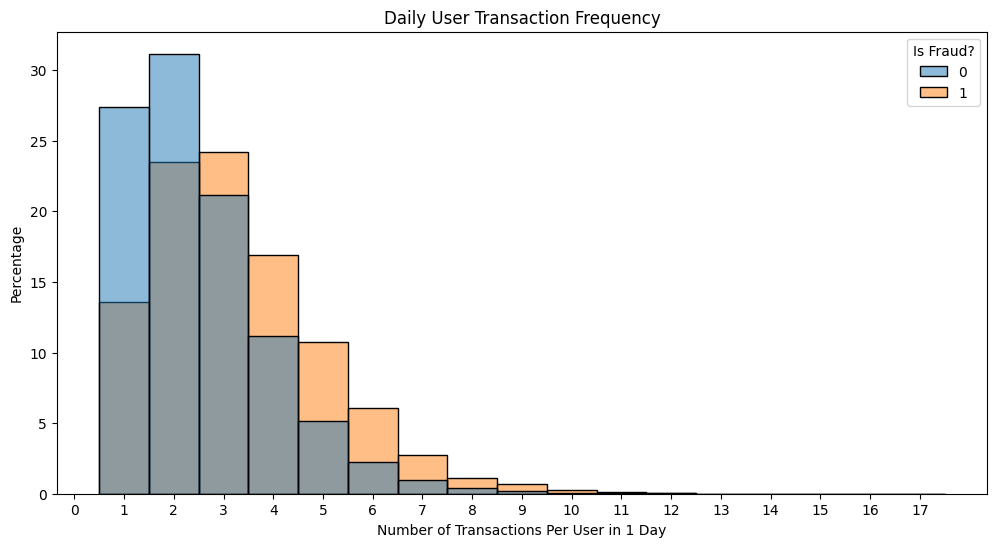

Is Fraud?
0    2.506185
1    3.299618
Name: User_Freq_Day, dtype: float64

In [45]:
# get frequency of user transactions in 1 day
df_daily_freq = df.with_columns([
    (pl.col("User").cast(pl.Utf8) + "_" + 
     pl.col("Date").cast(pl.Utf8)).alias("User_Date")
])

df_daily_freq = df_daily_freq.with_columns([
    pl.col("User_Date").count().over("User_Date").alias("User_Freq_Day")
])

user_daily_freq = df_daily_freq.select([
    "User_Freq_Day", "Is Fraud?"
]).to_pandas()

# plot distribution
plt.figure(figsize=(12, 6))
sns.histplot(
    data=user_daily_freq,
    x="User_Freq_Day",
    hue="Is Fraud?",
    kde=False,  
    stat="percent",
    common_norm=False,
    discrete=True
)
plt.title("Daily User Transaction Frequency")
plt.xlabel("Number of Transactions Per User in 1 Day")
plt.ylabel("Percentage")
max_val = int(user_daily_freq["User_Freq_Day"].max())
plt.xticks(np.arange(0, max_val + 1, 1))
plt.show()

# average daily user transactions
user_daily_freq.groupby("Is Fraud?")["User_Freq_Day"].mean()

### Fraud Network Analysis

#### Merchant Risk Network

**Merchant-to-Merchant network with common high-fraud users**

To identify merchants that are vulnerable to fraud 

<br>

Nodes: Merchants invovled in fraudulent activity
* linked to users with multiple fraud transactions

Edges: Fraud links between merchants
* merchants are connected if high-fraud users performed fraud at both merchants
* loops: user committed multiple fraud transactions at the same merchant

Edge Width: Number of shared fraudsters between merchants
* thicker edge = there are more high-fraud users that hit both merchants

Node Colour: Merchant risk score (in terms of financial loss)
* darker colour = higher-value fraud transactions

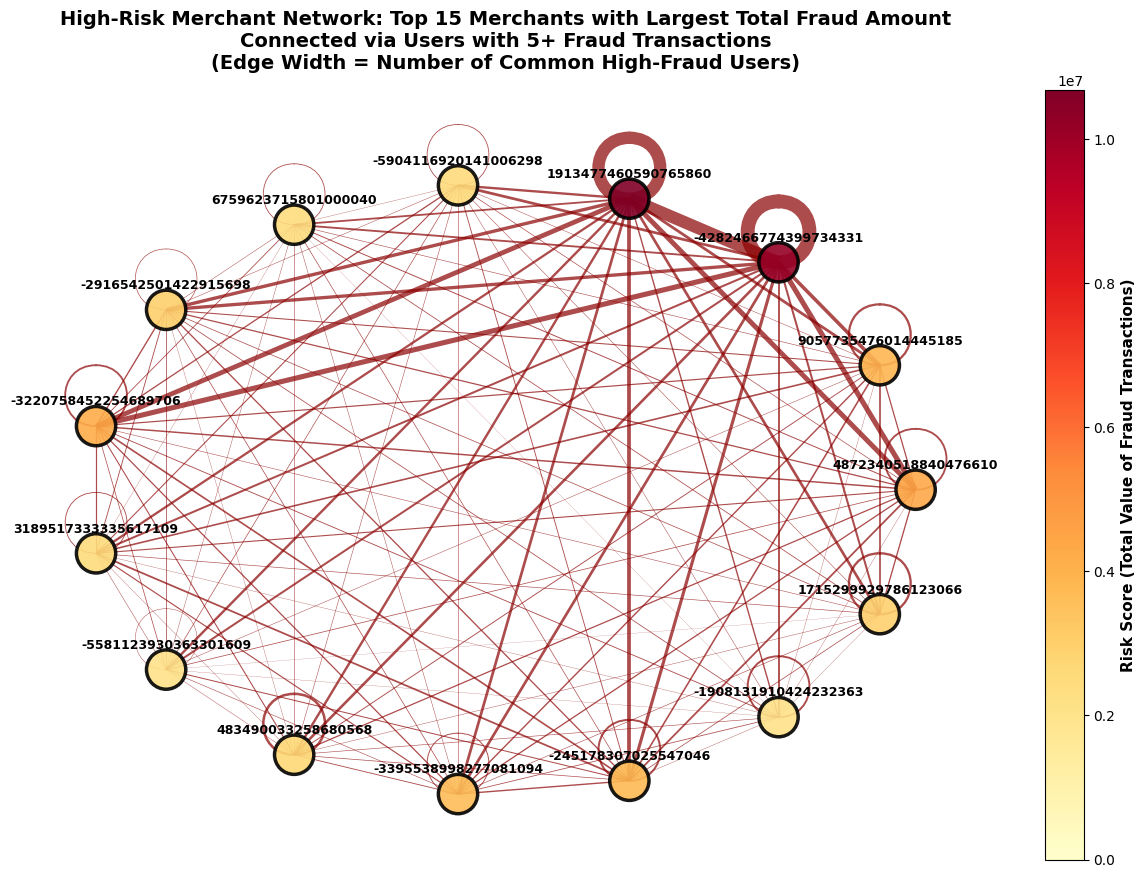

In [46]:
# identify high-fraud users 
high_fraud_users = (
    df.filter(pl.col("Is Fraud?") == 1)
      .group_by("User")
      .agg(pl.len().alias("fraud_count"))
      .filter(pl.col("fraud_count") >= 5)  # get users with 5+ fraud transactions
      .select("User")
      .to_series()
      .to_list()
)

fraud_subset = (
    df.filter(
        (pl.col("User").is_in(high_fraud_users)) & 
        (pl.col("Is Fraud?") == 1)
    )
    .select(["User", "Merchant Name", "Amount"])
    .to_pandas()
)

# create merchant-to-merchant connections via shared fraudsters
merchant_pairs = []
for user in high_fraud_users:
    user_merchants = fraud_subset[fraud_subset['User'] == user]['Merchant Name'].tolist()
    user_amounts = fraud_subset[fraud_subset['User'] == user]['Amount'].sum()
    
    for i in range(len(user_merchants)):
        for j in range(i+1, len(user_merchants)):
            merchant_pairs.append({
                'Merchant1': user_merchants[i],
                'Merchant2': user_merchants[j],
                'Shared_User': user,
                'Risk_Score': user_amounts
            })

if merchant_pairs:
    pairs_df = pd.DataFrame(merchant_pairs)
    
    # get total fraud amount and number of shared users between merchants
    pairs_agg = pairs_df.groupby(['Merchant1', 'Merchant2']).agg({
        'Risk_Score': 'sum',
        'Shared_User': 'count'
    }).reset_index()
    pairs_agg.columns = ['Merchant1', 'Merchant2', 'Total_Risk', 'Shared_Users']
    
    G = nx.from_pandas_edgelist(
        pairs_agg, 'Merchant1', 'Merchant2',
        edge_attr=['Total_Risk', 'Shared_Users']
    )
    
    if len(G.nodes()) > 0:

        # === MAIN NETWORK PLOT ===
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # node color by financial risk
        node_risks = {}
        for node in G.nodes():
            total_risk = sum([G[node][neighbor]['Total_Risk'] for neighbor in G.neighbors(node)])
            node_risks[node] = total_risk

        # keep top 15 merchants with largest total fraud amounts
        top_nodes = sorted(node_risks.items(), key=lambda x: x[1], reverse=True)[:15]
        top_node_names = [node for node, _ in top_nodes]

        G = G.subgraph(top_node_names).copy()
        
        max_risk = max(node_risks.values()) if node_risks else 1
        node_colors_vals = [node_risks[node] / max_risk for node in G.nodes()]

        # node size by degree
        node_sizes = [50 * G.degree(node) for node in G.nodes()]
        
        # draw nodes
        pos = nx.kamada_kawai_layout(G)
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                                      node_color=node_colors_vals,
                                      cmap=plt.cm.YlOrRd, vmin=0, vmax=1,
                                      alpha=0.9, edgecolors='black', linewidths=2.5,
                                      ax=ax)
        
        # edge width by number of shared users
        shared_users = [G[u][v]['Shared_Users'] for u, v in G.edges()]
        max_shared = max(shared_users) if shared_users else 1
        edge_widths = [10 * (su / max_shared) for su in shared_users]
        
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, 
                              edge_color='darkred', ax=ax)
        
        # labels merchants
        label_pos = {k: (v[0], v[1] + 0.08) for k, v in pos.items()}  
        nx.draw_networkx_labels(G, label_pos, font_size=9, font_weight='bold', ax=ax)
        
        # add colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, 
                                   norm=plt.Normalize(vmin=0, vmax=max_risk))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Risk Score (Total Value of Fraud Transactions)', fontweight='bold', fontsize=11)
        
        ax.set_title(f"High-Risk Merchant Network: Top 15 Merchants with Largest Total Fraud Amount\nConnected via Users with 5+ Fraud Transactions\n(Edge Width = Number of Common High-Fraud Users)", 
                     fontsize=14, fontweight='bold', pad=15)
        ax.axis('off')
        plt.show()

    else:
        print("No significant merchant network detected with current threshold.")
else:
    print("No merchant pairs found with current criteria.")

In [47]:
# create ranking dataframe
risk_ranking = []
for node in G.nodes():
    risk_ranking.append({
        'Merchant': str(node),
        'Risk Score': node_risks[node],
        'Connections': G.degree(node),
        'Total Fraudsters': sum([G[node][neighbor]['Shared_Users'] 
                                for neighbor in G.neighbors(node)])
    })

rank_df = pd.DataFrame(risk_ranking).sort_values('Risk Score', ascending=False)
rank_df['Rank'] = range(1, len(rank_df) + 1)
rank_df = rank_df[['Rank', 'Merchant', 'Risk Score', 'Connections', 'Total Fraudsters']]

# print summary
print("\n" + "="*60)
print("HIGH-RISK MERCHANT NETWORK ANALYSIS")
print("="*60)
print(f"Total high-fraud users analyzed: {len(high_fraud_users)}")
print(f"High-risk merchants in network: {len(G.nodes())}")
print(f"Merchant connections: {len(G.edges())}")
print(f"\nTop 5 highest-risk merchants:")
for idx, row in rank_df.head().iterrows():
    print(f"  {int(row['Rank'])}. {row['Merchant'][:30]}")
    print(f"     Risk: {row['Risk Score']:.2f} | Connections: {int(row['Connections'])} | Fraudsters: {int(row['Total Fraudsters'])}")
print("="*60)


HIGH-RISK MERCHANT NETWORK ANALYSIS
Total high-fraud users analyzed: 902
High-risk merchants in network: 15
Merchant connections: 120

Top 5 highest-risk merchants:
  1. 1913477460590765860
     Risk: 10687603.17 | Connections: 16 | Fraudsters: 1292
  2. -4282466774399734331
     Risk: 10204956.89 | Connections: 16 | Fraudsters: 1333
  3. 4872340518840476610
     Risk: 4365750.88 | Connections: 16 | Fraudsters: 526
  4. -3220758452254689706
     Risk: 4248785.89 | Connections: 16 | Fraudsters: 522
  5. 9057735476014445185
     Risk: 3856490.13 | Connections: 16 | Fraudsters: 442


In [ ]:
row = df.filter(pl.col("Merchant Name") == 1913477460590765860)
row = row.to_pandas()
print(row)

print("\n=== Type of Transaction ===\n")                  
print(row["Use Chip"].unique())

print("\n=== Number of Fraudulent Transactions ===\n")                           # 0.28% of all transactions are fraudulent
print(row["Is Fraud?"].value_counts())

print("\n=== Number of Fraudulent Transactions per Transaction Type===\n")       # 91.9% of fraud are online
fraud_txns = row[row["Is Fraud?"] == 1]
print(fraud_txns["Use Chip"].value_counts())

print("\n=== Fraud Count by State===\n")                                         # besides slightly more frequent fraud in Ohio, 
fraud_by_state = (                                                               # in-person fraud seems to be spread out across states
    row.groupby("Merchant State")["Is Fraud?"]
       .sum()
       .reset_index(name="fraud_count")
       .query("fraud_count > 0")
       .sort_values("fraud_count", ascending=False)
)
print(fraud_by_state)

        User  Card  Year  Month  Day   Time  Amount           Use Chip  \
0       1730     1  2017     10   21  18:37  210.99   Chip Transaction   
1        241     3  2016     12    9  07:51   19.79  Swipe Transaction   
2       1819     0  2019      9    8  05:21  115.96   Chip Transaction   
3        759     1  2004      7   25  22:28   76.84  Swipe Transaction   
4        322     1  2008      8    4  16:37   52.78  Swipe Transaction   
...      ...   ...   ...    ...  ...    ...     ...                ...   
224831   648     3  2006      7   14  14:34   48.06  Swipe Transaction   
224832  1418     2  2019      9    7  22:28    4.75   Chip Transaction   
224833   233     2  2010      9   11  09:45    8.91  Swipe Transaction   
224834   376     0  2009      6   16  11:11   76.89  Swipe Transaction   
224835   366     1  2019     12    9  13:27    3.30   Chip Transaction   

              Merchant Name Merchant City  ... Card on Dark Web  \
0       1913477460590765860   Morgan Hill  .

In [ ]:
row = df.filter(pl.col("Merchant Name") == -4282466774399734331)
row = row.to_pandas()
print(row)

print("\n=== Type of Transaction ===\n")                  
print(row["Use Chip"].unique())

print("\n=== Number of Fraudulent Transactions ===\n")                           # 0.1% of all transactions are fraudulent
print(row["Is Fraud?"].value_counts())

print("\n=== Number of Fraudulent Transactions per Transaction Type===\n")       # 93.5% of fraud are online
fraud_txns = row[row["Is Fraud?"] == 1]
print(fraud_txns["Use Chip"].value_counts())

print("\n=== Fraud Count by State===\n")                                         # besides slightly more frequent fraud in Ohio, 
fraud_by_state = (                                                               # in-person fraud seems to be spread out across states
    row.groupby("Merchant State")["Is Fraud?"]
       .sum()
       .reset_index(name="fraud_count")
       .query("fraud_count > 0")
       .sort_values("fraud_count", ascending=False)
)
print(fraud_by_state)

        User  Card  Year  Month  Day   Time  Amount           Use Chip  \
0       1781     1  2008      6    4  12:25     0.0  Swipe Transaction   
1       1254     2  2011      8   13  10:42    40.0  Swipe Transaction   
2        488     1  2009      1   12  14:20    40.0  Swipe Transaction   
3        619     1  2019      1    6  16:53   100.0   Chip Transaction   
4          2     1  2002      8   29  15:40    20.0  Swipe Transaction   
...      ...   ...   ...    ...  ...    ...     ...                ...   
451194   999     3  2008      3   12  21:18   140.0  Swipe Transaction   
451195  1021     0  2006      3   11  12:50    20.0  Swipe Transaction   
451196  1275     2  2011      4   11  06:56   180.0  Swipe Transaction   
451197   486     4  2005      9   28  16:36   120.0  Swipe Transaction   
451198  1629     2  2009     12   19  12:31   140.0  Swipe Transaction   

              Merchant Name  Merchant City  ... Card on Dark Web  \
0      -4282466774399734331      Charlotte 

In [51]:
targets = [-4282466774399734331, 1913477460590765860]

fraud_two_merchants = (
    df.filter((pl.col("Is Fraud?") == 1) &
              (pl.col("Merchant Name").is_in(targets)))
)

# get users who committed fraud at both merchants
user_by_merchant = (
    fraud_two_merchants
    .group_by(["User", "Merchant Name"])
    .agg(pl.len().alias("fraud_count"))
)

intersection_users = (
    user_by_merchant
    .group_by("User")
    .agg([
        pl.col("Merchant Name").n_unique().alias("merchant_count"),
        pl.col("fraud_count").sum().alias("total_fraud")
    ])
    .filter(pl.col("merchant_count") == 2)  
)

users_intersection_list = intersection_users["User"].to_list()

fraud_details = (
    fraud_two_merchants
    .filter(pl.col("User").is_in(users_intersection_list))
    .sort(["User", "DateTime"])
)

fraud_details

User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Zip_str,DateTime,Date,Hour,User_card,State,FICO Score,Yearly Income - Person,Total Debt,Num Credit Cards,Card Brand,Credit Limit,Card on Dark Web,merchant_state_diff,amount_is_refund,amount_log,hour_angle,hour_sin,hour_cos,card_kappa,von_mises_likelihood_card,Is Fraud?
i64,i64,i64,i64,i64,str,f64,str,i64,str,str,f64,i64,str,str,str,str,i64,str,str,i64,f64,f64,i64,str,f64,str,bool,i64,f64,f64,f64,f64,f64,f64,i64
2,4,2013,10,11,"""07:21""",142.82,"""Online Transaction""",-4282466774399734331,"""ONLINE""","""ONLINE""",null,4829,null,"""ONL""","""2013-10-11T07:21:00.000000""","""2013-10-11""",7,"""2_4""","""CA""",698,33483.0,196.0,5,"""Mastercard""",16055.0,"""No""",true,0,4.968563,1.831141,0.966301,-0.257414,0.437183,0.76561,1
2,4,2013,10,12,"""04:03""",49.38,"""Online Transaction""",1913477460590765860,"""ONLINE""","""ONLINE""",null,5300,null,"""ONL""","""2013-10-12T04:03:00.000000""","""2013-10-12""",4,"""2_4""","""CA""",698,33483.0,196.0,5,"""Mastercard""",16055.0,"""No""",true,0,3.919594,1.041671,0.863249,0.504779,0.437183,1.059344,1
2,4,2015,9,2,"""13:40""",73.26,"""Online Transaction""",1913477460590765860,"""ONLINE""","""ONLINE""",null,5300,null,"""ONL""","""2015-09-02T13:40:00.000000""","""2015-09-02""",13,"""2_4""","""CA""",698,33483.0,196.0,5,"""Mastercard""",16055.0,"""No""",true,0,4.307572,-1.355539,-0.976921,0.213599,0.437183,1.285581,1
15,4,2008,3,2,"""21:25""",187.15,"""Online Transaction""",-4282466774399734331,"""ONLINE""","""ONLINE""",null,4829,null,"""ONL""","""2008-03-02T21:25:00.000000""","""2008-03-02""",21,"""15_4""","""OK""",723,23123.0,5079.0,6,"""Mastercard""",6000.0,"""No""",true,0,5.23724,0.729257,0.666316,0.74567,0.437183,1.206903,1
15,2,2016,3,3,"""13:38""",164.16,"""Online Transaction""",1913477460590765860,"""ONLINE""","""ONLINE""",null,5300,null,"""ONL""","""2016-03-03T13:38:00.000000""","""2016-03-03""",13,"""15_2""","""OK""",723,23123.0,5079.0,6,"""Visa""",5800.0,"""No""",true,0,5.106915,-1.364266,-0.978748,0.205065,0.437183,1.281561,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1962,0,2008,6,5,"""10:37""",254.87,"""Online Transaction""",-4282466774399734331,"""ONLINE""","""ONLINE""",null,4829,null,"""ONL""","""2008-06-05T10:37:00.000000""","""2008-06-05""",10,"""1962_0""","""ID""",600,28738.0,48786.0,1,"""Visa""",1436.0,"""No""",true,0,5.54467,-2.154027,-0.834688,-0.550724,0.437183,0.922192,1
1962,0,2013,10,18,"""09:10""",49.64,"""Online Transaction""",1913477460590765860,"""ONLINE""","""ONLINE""",null,5300,null,"""ONL""","""2013-10-18T09:10:00.000000""","""2013-10-18""",9,"""1962_0""","""ID""",600,28738.0,48786.0,1,"""Visa""",1436.0,"""No""",true,0,3.924742,2.362594,0.702567,-0.711617,0.437183,0.666543,1
1997,1,2006,6,6,"""18:02""",56.81,"""Swipe Transaction""",-4282466774399734331,"""North Bergen""","""NJ""",7047.0,4829,null,"""704""","""2006-06-06T18:02:00.000000""","""2006-06-06""",18,"""1997_1""","""NJ""",779,30942.0,71066.0,3,"""Amex""",6900.0,"""No""",false,0,4.057162,-0.044797,-0.044782,0.998997,0.437183,1.507369,1


#### Fraud Ring Detection

**User-to-User network of users who committed fraud at the same merchants**

To detect potential fraud rings

In [48]:
fraud_txns = df.filter(pl.col("Is Fraud?") == 1).to_pandas()

# get users who share merchants (potential collusion)
merchant_users = fraud_txns.groupby('Merchant Name')['User'].apply(list).to_dict()

# create user-to-user network based on common merchants
user_connections = []
for merchant, users_list in merchant_users.items():
    if len(users_list) > 1:  # multiple users at same merchant
        for i in range(len(users_list)):
            for j in range(i+1, len(users_list)):
                user_connections.append({
                    'User1': users_list[i],
                    'User2': users_list[j],
                    'Shared_Merchant': merchant,
                    'Weight': 1
                })

if user_connections:
    edge_df = pd.DataFrame(user_connections)

    # aggregate weights based on number of common merchants
    edge_df = edge_df.groupby(['User1', 'User2']).agg({
        'Weight': 'sum',
        'Shared_Merchant': lambda x: list(x)
    }).reset_index()
    
    # filter for users sharing 5+ merchants (fraud at many common merchants is suspicious)
    edge_df = edge_df[edge_df['Weight'] >= 5]
    
    G = nx.from_pandas_edgelist(edge_df, 'User1', 'User2', edge_attr=['Weight', 'Shared_Merchant'])
    
    # remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # only keep largest connected components
    if len(G.nodes()) > 0:
        components = sorted(nx.connected_components(G), key=len, reverse=True)
        nodes_to_keep = set()
        for comp in components[:3]:
            if len(comp) >= 3:  
                nodes_to_keep.update(comp)
        
        G = G.subgraph(nodes_to_keep).copy()
    
    if len(G.nodes()) > 0:
        # find communities (possible fraud rings)
        communities = list(nx.community.greedy_modularity_communities(G))

print("="*80)
print("FRAUD RING ANALYSIS")
print("="*80)
print(f"Total fraud rings detected: {len(communities)}")
print(f"Total users involved: {len(G.nodes())}")
print(f"Total connections: {len(G.edges())}")

for i, comm in enumerate(communities, 1):
    subgraph = G.subgraph(comm)
    users_list = list(comm)
    print(f"\nRing {i}:")
    print(f"  - Users: {len(comm)} (showing first few: {users_list[:10]})")
    print(f"  - Internal connections: {len(subgraph.edges())}")
    
    # get most shared merchants
    all_merchants = []
    for u, v in subgraph.edges():
        all_merchants.extend(G[u][v]['Shared_Merchant'])
    
    if all_merchants:
        top_merchants = Counter(all_merchants).most_common(3)
        print(f"  - Top shared merchants: {[m[0] for m in top_merchants]}")

    # transactions of users in this ring
    ring_txns = fraud_txns[fraud_txns['User'].isin(users_list)]

    # get home states of users in ring
    home_states = ring_txns.groupby('State')['User'].nunique().sort_values(ascending=False).head(10)
    print(f"  - Top User States:")
    for state, count in home_states.items():
        print(f"      {state}: {count} user(s)")

    # get merchant states of transactions in ring
    merchant_states = ring_txns['Merchant State'].value_counts().head(10)
    print(f"  - Top Merchant States:")
    for state, count in merchant_states.items():
        print(f"      {state}: {count} transactions(s)")
    
    # get commonly targeted MCC 
    common_mcc = ring_txns['MCC'].value_counts().head(10)
    print(f"  - Top MCC codes:")
    for mcc, count in common_mcc.items():
        print(f"      {mcc}: {count} transactions(s)")

print("="*80)

FRAUD RING ANALYSIS
Total fraud rings detected: 8
Total users involved: 872
Total connections: 20585

Ring 1:
  - Users: 333 (showing first few: [0, 2, 1029, 1032, 1036, 1038, 1049, 1059, 1062, 40])
  - Internal connections: 3290
  - Top shared merchants: [-4282466774399734331, -245178307025547046, 9057735476014445185]
  - Top User States:
      CA: 37 user(s)
      TX: 30 user(s)
      FL: 27 user(s)
      NY: 23 user(s)
      PA: 14 user(s)
      MD: 12 user(s)
      IN: 10 user(s)
      OH: 10 user(s)
      GA: 10 user(s)
      NC: 9 user(s)
  - Top Merchant States:
      ONLINE: 2389 transactions(s)
      Italy: 1151 transactions(s)
      OH: 128 transactions(s)
      CA: 94 transactions(s)
      Algeria: 74 transactions(s)
      Turkey: 63 transactions(s)
      FL: 58 transactions(s)
      Haiti: 44 transactions(s)
      TX: 44 transactions(s)
      Mexico: 38 transactions(s)
  - Top MCC codes:
      5311: 847 transactions(s)
      5310: 332 transactions(s)
      5300: 196 transac